## Simulating spectral graph model frequency spectrum with `spectrome`: Usage example

![](./classes.png)

### Import modules with respective paths

In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward, network_transfer_macrostable_microintensity_extrastimulus, est_FC
from spectrome.utils import functions, path
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np

### Create new `Brain()` and populate it

Let us first set up a `Brain()` and its attributes: `connectome`, `ordering`, and `ntf_params`

In [2]:
new_brain = Brain.Brain()

hcp_dir = path.get_data_path() # connectome information is in /data/ dir
new_brain.add_connectome(hcp_dir) # Use default files in /data/

Let's see what the attributes of brain are:

In [3]:
vars(new_brain).keys()

dict_keys(['connectome', 'reducedConnectome', 'distance_matrix', 'permutation', 'ordering', 'laplacian', 'eigenvalues', 'norm_eigenmodes', 'regular_eigenvalues', 'regular_laplacian', 'norm_regular_eigenmodes', 'raw_regular_eigenvectors', 'ntf_params'])

And which have been initialized, so far

In [4]:
vars(new_brain)

{'connectome': array([[0.0000e+00, 5.4250e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4250e+00, 0.0000e+00, 4.2118e+02, ..., 1.2500e-02, 3.0000e-01,
         6.6250e-01],
        [0.0000e+00, 4.2118e+02, 0.0000e+00, ..., 0.0000e+00, 6.2500e-02,
         9.3750e-01],
        ...,
        [0.0000e+00, 1.2500e-02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.1570e+02],
        [0.0000e+00, 3.0000e-01, 6.2500e-02, ..., 0.0000e+00, 0.0000e+00,
         7.9550e+01],
        [0.0000e+00, 6.6250e-01, 9.3750e-01, ..., 1.1570e+02, 7.9550e+01,
         0.0000e+00]]),
 'reducedConnectome': None,
 'distance_matrix': array([[ 0.    , 38.597 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [38.597 ,  0.    , 11.69  , ...,  2.0156, 14.584 , 37.644 ],
        [ 0.    , 11.69  ,  0.    , ...,  0.    ,  2.0352, 20.158 ],
        ...,
        [ 0.    ,  2.0156,  0.    , ...,  0.    ,  0.    , 13.273 ],
        [ 0.    , 14.584 ,  2.0352, ...,  0.    ,  0.    , 

We have the connectome (`Cdk_conn`), the distance matrix (`Ddk_conn`), the permanent hcp ordering (`permHCP`), and some defaul parameters for the `network_transfer_function` (`ntf_params`).

Now, the `network_transfer_function` has 4 input parameters:
- `C`: the **reduced** connectivity matrix
- `D`: the distance matrix
- `parameters`: the 7 ntf parameters
- `w`: the frequency at which the ntf will be calculated at.
    
We have all but the first parameter since we need to convert the connectivity matrix to a **reduced** form. This is done by applying 2 functions to the `new_brain`:
- `new_brain.bi_symmetric_c()`
- `new_brain.reduce_extreme_dir()`

In [5]:
# Some re-ordering and normalizing (reduced):
new_brain.reorder_connectome(new_brain.connectome, new_brain.distance_matrix)
# new_brain.connectome = SC_FA_template
new_brain.bi_symmetric_c()
new_brain.reduce_extreme_dir()

print(new_brain.reducedConnectome.shape)

(86, 86)


In [6]:
FC = est_FC.build_fc_freq(new_brain, new_brain.ntf_params ,np.arange(0,68))

(86, 86)


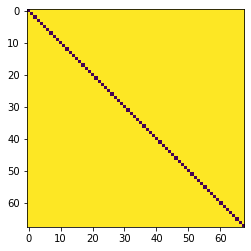

In [8]:
plt.imshow(FC)

For the Desikan-Killiany atlas, we have 86 brain regions.|

In [118]:
from scipy.io import loadmat
import xarray as xr
## individual connectomes, this is a Nregion x Nregion x Nsubjects array:
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values
print(ind_conn.shape)
ind_conn_av = np.mean(ind_conn,2)
print(ind_conn_av.shape)

(86, 86, 36)
(86, 86)


In [109]:
sc_fa_tinnitus = loadmat("/data/rajlab1/shared_data/datasets/SGM_fit/tinnitus_controls/SC_FA_tinnitus.mat")

In [110]:
SC_template = sc_fa_tinnitus["sc_tinnitus"][0][0][0]
FA_template = sc_fa_tinnitus["sc_tinnitus"][0][0][1]
SC_FA_template = sc_fa_tinnitus["sc_tinnitus"][0][0][2]

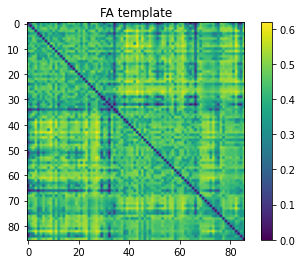

In [98]:
plt.imshow(FA_template);
plt.colorbar();
plt.title('FA template');

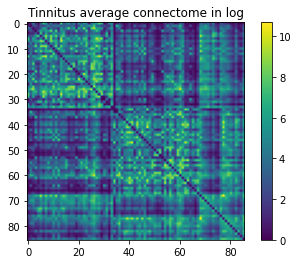

In [121]:
plt.imshow(np.log(SC_template+1));
plt.title('Tinnitus average connectome in log');
plt.colorbar();

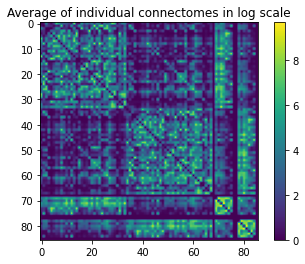

In [122]:
plt.imshow(np.log(ind_conn_av+1));
plt.title('Average of individual connectomes in log scale');
plt.colorbar();

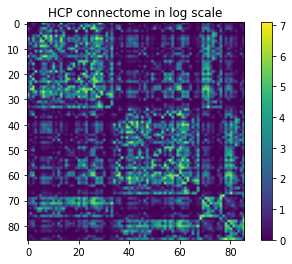

In [123]:
plt.imshow(np.log(new_brain.connectome+1));
plt.title('HCP connectome in log scale');
plt.colorbar();

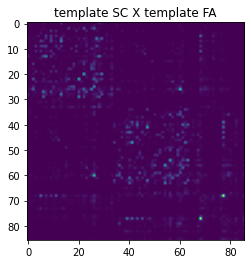

In [93]:
plt.imshow(SC_FA_template);
plt.title('template SC X template FA');

In [94]:
FA_spatial = np.zeros((86,1))
for i in range(86):
    FA_spatial[i] = np.sum(FA_template[:,i]) + np.sum(FA_template[i,:])

In [96]:

# filename = f'../results/spatial/FA_template.p'
# with open(filename, 'wb') as f:
#     pkl.dump(FA_spatial, f)

### Calculating network transfer function for a *range* of frequencies

Now loop over a range of frequencies of interest and calculate the network transfer function.

1. First setup such frequencies:

In [6]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)

In [6]:
import xarray as xr
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values

In [7]:
AD_empirical = xr.open_dataarray("/data/rajlab1/shared_data/datasets/SGM_fit/larger_dataset/fmegallAD_Kamalini.nc")
fvec = AD_empirical["frequencies"].values

In [10]:
import pandas as pd
w_10I_hcp = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/fmegall_tauiu200_gu10_macrostable_largerdataset_1spatial_nodb_10weightedcorr_lowspeed/fmegallAD_gei_globalSGM_relaxedbounds.csv",delimiter=",")
w_10I_hcp_sorted = w_10I_hcp[np.argsort(w_10I_hcp[:,10])]
df_params=pd.DataFrame({'tau_e':w_10I_hcp_sorted[:,0], 'tau_i':w_10I_hcp_sorted[:,1], 'alpha':w_10I_hcp_sorted[:,2], 'speed':w_10I_hcp_sorted[:,3], 'gei':w_10I_hcp_sorted[:,4], 'gii':w_10I_hcp_sorted[:,5], 'tauC':w_10I_hcp_sorted[:,6]})

In [7]:
import pandas as pd
w_10I_hcp = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/chang_tauiu200_g10_macrostable_spatial_pw1_nodb/onlyuk_1spectral_1spatial_10weightedcorr_org_templateconnectome_lowspeed.csv",delimiter=",")
w_10I_hcp_sorted = w_10I_hcp[np.argsort(w_10I_hcp[:,10])]
df_params=pd.DataFrame({'tau_e':w_10I_hcp_sorted[:,0], 'tau_i':w_10I_hcp_sorted[:,1], 'alpha':w_10I_hcp_sorted[:,2], 'speed':w_10I_hcp_sorted[:,3], 'gei':w_10I_hcp_sorted[:,4], 'gii':w_10I_hcp_sorted[:,5], 'tauC':w_10I_hcp_sorted[:,6]})

In [10]:
w = 2 * np.pi * fvec[0]
_, freq_response, eigenvalues, eigenvectors = network_transfer_macrostable.network_transfer_local_alpha(new_brain, new_brain.ntf_params, w)

In [52]:
Xh = np.matmul(np.matrix.getH(eigenvectors[:,:68]),  np.matmul(np.array(ind_psd[:,0,0]), eigenvectors[:68,:]))

In [28]:
Hloc=0
for i in range(68):
    Hloc += (np.linalg.norm(freq_response[0])**2/freq_response[0]) * Xh[i,i]

In [57]:
Hloc=np.zeros((len(fvec),1),dtype=complex)

for i in range(len(fvec)):
    w = 2 * np.pi * fvec[i]
    _, freq_response, eigenvalues, eigenvectors = network_transfer_macrostable.network_transfer_local_alpha(new_brain, new_brain.ntf_params, w)
    Xh = np.matmul(np.matrix.getH(eigenvectors[:,:68]),  np.matmul(np.array(ind_psd[:,i,0]), eigenvectors[:68,:]))
    for j in range(68):
        Hloc[i] += (np.linalg.norm(freq_response[i])**2/freq_response[i]) * Xh[j]

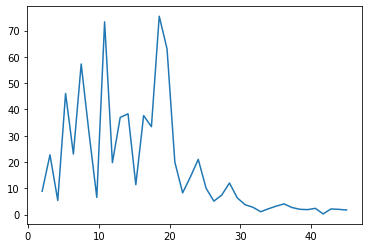

In [58]:
plt.plot(fvec,np.abs(Hloc))

In [64]:
Hloc=np.zeros((len(fvec),36),dtype=complex)
for s in range(36):
    data_dir = path.get_data_path()
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
#     brain.connectome = C_ind # re-assign connectome to individual connectome
#     brain.connectome = np.multiply(C_ind, FA_template)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
#     brain.distance_matrix = get_mean_C(brain.distance_matrix)

    brain.ntf_params["tau_e"] = df_params['tau_e'][s]/1000
    brain.ntf_params["tau_i"] = df_params['tau_i'][s]/1000
    brain.ntf_params["alpha"] = df_params['alpha'][s]
    brain.ntf_params["speed"] = df_params['speed'][s]
    brain.ntf_params["gei"] = df_params['gei'][s]
    brain.ntf_params["gii"] = df_params['gii'][s]
    brain.ntf_params["tauC"] = df_params['tauC'][s]/1000
    for i in range(len(fvec)):
        w = 2 * np.pi * fvec[i]
        _, freq_response, eigenvalues, eigenvectors = network_transfer_macrostable.network_transfer_local_alpha(new_brain, new_brain.ntf_params, w)
        Xh = np.matmul(np.matrix.getH(eigenvectors[:,:68]),  np.matmul(np.array(ind_psd[:,i,s]), eigenvectors[:68,:]))
        for j in range(68):
            Hloc[i,s] += (np.linalg.norm(freq_response[i])**2/freq_response[i]) * Xh[j]
    

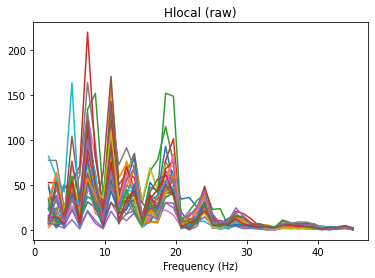

In [67]:
plt.plot(fvec,np.abs(Hloc));
plt.title('Hlocal (raw)'); plt.xlabel('Frequency (Hz)');

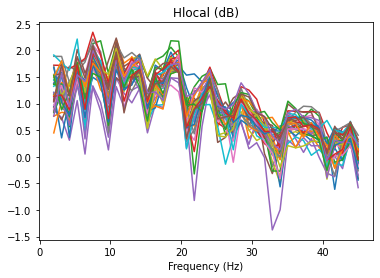

In [68]:
plt.plot(fvec,np.log10(np.abs(Hloc)));
plt.title('Hlocal (dB)'); plt.xlabel('Frequency (Hz)');

2. Then calculate the frequency response:

In [8]:
new_brain.ntf_params["tau_e"] = np.mean(df_params['tau_e'][:])/1000
new_brain.ntf_params["tau_i"] = np.mean(df_params['tau_i'][:])/1000
new_brain.ntf_params["alpha"] = np.mean(df_params['alpha'][:])
new_brain.ntf_params["speed"] = np.mean(df_params['speed'][:])
new_brain.ntf_params["gei"] = np.mean(df_params['gei'][:])
new_brain.ntf_params["gii"] = np.mean(df_params['gii'][:])
new_brain.ntf_params["tauC"] = np.mean(df_params['tauC'][:])/1000

In [9]:
# Compute for all frequencies in fvec:
model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)

print(model_spectrum.shape)
print(freq_response.shape)
print(eigvectors.shape)

(86, 40)
(40, 86)
(40, 86, 86)


The output for this example is 86 brain regions and 40 frequency bins.

### Plotting the simulated frequency spectra:

Text(0.5, 1.0, 'params are mean of ad params')

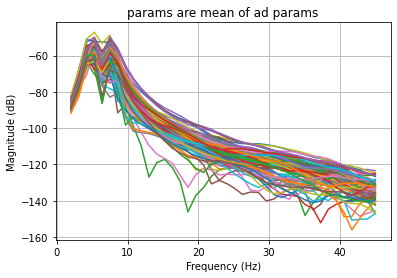

In [10]:
for g in range(len(model_spectrum)):
    spectrum = np.abs(model_spectrum[g,:])
    plt.plot(fvec,functions.mag2db(spectrum))

plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('params are mean of ad params')

In [11]:
new_brain.ntf_params

{'tau_e': 0.015087305656072853,
 'tau_i': 0.04691980565390131,
 'alpha': 0.7249506667414845,
 'speed': 3.8627170697602455,
 'gei': 2.97634838058656,
 'gii': 7.805308995645204,
 'tauC': 0.015841128049202808}

Text(0.5, 1.0, 'tau_i = 5')

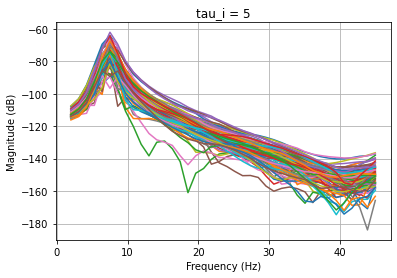

In [12]:
new_brain.ntf_params["tau_i"] = 5/1000
model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)

for g in range(len(model_spectrum)):
    spectrum = np.abs(model_spectrum[g,:])
    plt.plot(fvec,functions.mag2db(spectrum))

plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('tau_i = 5')

Text(0.5, 1.0, 'tau_G = 30')

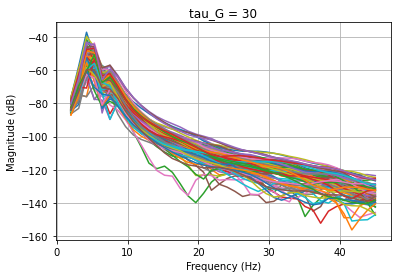

In [13]:
new_brain.ntf_params["tau_e"] = np.mean(df_params['tau_e'][:])/1000
new_brain.ntf_params["tau_i"] = np.mean(df_params['tau_i'][:])/1000
new_brain.ntf_params["alpha"] = np.mean(df_params['alpha'][:])
new_brain.ntf_params["speed"] = np.mean(df_params['speed'][:])
new_brain.ntf_params["gei"] = np.mean(df_params['gei'][:])
new_brain.ntf_params["gii"] = np.mean(df_params['gii'][:])
new_brain.ntf_params["tauC"] = 30/1000

model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)

for g in range(len(model_spectrum)):
    spectrum = np.abs(model_spectrum[g,:])
    plt.plot(fvec,functions.mag2db(spectrum))

plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('tau_G = 30')

In [2]:
from scipy.io import loadmat

In [9]:
mica_micro_intensity = np.squeeze(loadmat('/data/rajlab1/shared_data/datasets/MICA/micro_intensity_mean.mat')['micro_intensity_mean'])

In [6]:
np.squeeze(mica_micro_intensity['micro_intensity_mean'])

array([0.97954598, 1.04663377, 1.02790066, 0.94043892, 1.04313322,
       0.99733067, 1.00177753, 1.01638462, 0.9571026 , 0.96533643,
       1.02622411, 0.94658824, 1.05415383, 1.00880156, 1.00964773,
       0.98679822, 1.01990585, 1.04318387, 1.02197809, 0.92696738,
       0.98916341, 1.00436371, 0.97453739, 0.98066488, 1.05556387,
       1.03784686, 1.0589785 , 0.98833544, 0.99204057, 1.00627483,
       1.09498868, 1.08781456, 0.92294953, 1.01250139, 0.95807567,
       1.04825985, 1.02376887, 0.92164065, 1.0110499 , 0.95519104,
       0.9751905 , 0.9825796 , 0.94068902, 0.94086161, 1.0404832 ,
       0.9220218 , 1.05803126, 1.00346396, 0.9767829 , 0.97642081,
       1.01982408, 1.03889422, 1.02288687, 0.90707908, 0.97632137,
       0.9971192 , 0.96877856, 0.96040744, 1.06150604, 1.03674799,
       1.05804678, 0.96981431, 0.9854739 , 0.98565527, 1.0801833 ,
       1.0483975 , 0.90907888, 1.01341773])